In [1]:
import matplotlib
import lmfit
import pandas as pd
import matplotlib.pyplot as plt
from lmfit.models import LorentzianModel, ExponentialModel, PowerLawModel
from numpy import linspace
plt.close('all')
from pprint import pprint
from datetime import timedelta, date

In [2]:
last_k = 10
df_us = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv")
df_india = pd.read_csv("data/indiatotalupdated.csv")

In [3]:
df_us.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


In [4]:
df_india

,Country/Region,10-03-2020,11-03-2020,12-03-2020,13-03-2020,14-03-2020,15-03-2020,16-03-2020,17-03-2020,18-03-2020,...,30-03-2020,31-03-2020,01-04-2020,02-04-2020,03-04-2020,04-04-2020,05-04-2020,06-04-2020,07-04-2020,08-04-2020
0,India,47,60,73,82,84,110,114,137,151,...,1328,1619,1998,2545,3059,3588,4289,4778,5351,5865


Transform India data : Since we iterate over dates, it is easier to have dates as rows instead of columns 
------------------

In [5]:
def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

start_dt = date(2020, 3, 10)
end_dt = date(2020, 4, 7)
analysis_dates = []
for dt in daterange(start_dt, end_dt):
    analysis_dates.append(dt.strftime("%Y-%m-%d"))

In [6]:
# Transform India data
india_data = []

for index, row in df_india.iterrows():
    i=1
    for d in analysis_dates:
        data_point = {
            'date' : d,
            'cases' : row[i],
            'Country':row[0]
        }
        i=i+1
        india_data.append(data_point)

df_india_transform = pd.DataFrame(india_data)

In [7]:
df_india


,Country/Region,10-03-2020,11-03-2020,12-03-2020,13-03-2020,14-03-2020,15-03-2020,16-03-2020,17-03-2020,18-03-2020,...,30-03-2020,31-03-2020,01-04-2020,02-04-2020,03-04-2020,04-04-2020,05-04-2020,06-04-2020,07-04-2020,08-04-2020
0,India,47,60,73,82,84,110,114,137,151,...,1328,1619,1998,2545,3059,3588,4289,4778,5351,5865


In [8]:
df_india_transform

,date,cases,Country
0,2020-03-10,47,India
1,2020-03-11,60,India
2,2020-03-12,73,India
3,2020-03-13,82,India
4,2020-03-14,84,India
5,2020-03-15,110,India
6,2020-03-16,114,India
7,2020-03-17,137,India
8,2020-03-18,151,India
9,2020-03-19,173,India


Total number of cases for each date
--

In [9]:
df_india_transform[df_india_transform['Country'] == 'India'].head()

,date,cases,Country
0,2020-03-10,47,India
1,2020-03-11,60,India
2,2020-03-12,73,India
3,2020-03-13,82,India
4,2020-03-14,84,India


Generate plots
---

In [10]:
def label(l, df):
    return 'Predictions as of ' + str(df.date[l-1])


def generate_prediction_plot(df):
    model = PowerLawModel()
    params = model.guess(df.cases, x=df.cases.index)
    last = len(df)
    answers = {}
    for i in range(last_k):
        ind = last-i
        answers[i]= {'label': label(ind, df), 'model': model.fit(df.cases[:ind], params, x=df.cases.index[:ind])}
        df[label(ind, df)] = list(map(lambda x: int(x), answers[i]['model'].eval(x=df.cases.index)))
    return df[['cases'] + [label(last-i, df) for i in range(last_k)]][10:].plot()


def get_plots(Country):
    df_india_transform_e = df_india_transform[df_india_transform.Country == Country]
    ind_Country = df_india_transform_e.reset_index()
    return generate_prediction_plot(ind_Country)

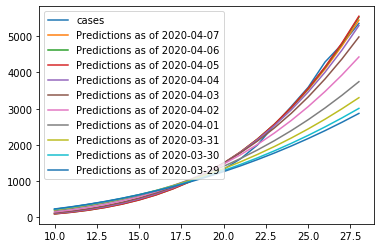

In [11]:
plot = get_plots('India')
fig = plot.get_figure()
fig.savefig("8april.jpeg")
plot